# Triplet loss

Example showcasing how to use skorch with triplet loss.

At first glance, it might not be quite obvious how to implement something like nets that use contrastive loss or triplet loss with skorch. Here is an example of using triplet loss that could be used as a starting point.

## Imports

In [1]:
import numpy as np
from skorch import NeuralNet
import torch
from torch import nn
from skorch.toy import MLPModule
from skorch.dataset import Dataset
from torch.utils.data import Sampler, BatchSampler

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
plt.style.use('seaborn')

In [5]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare data

Use an artificial dataset consisting of 3 classes.

In [6]:
X, y = make_classification(2000, n_features=50, n_informative=40, n_classes=3)

In [7]:
X = X.astype(np.float32)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

## Custom code

### Sampling of positives and negatives to create triplets

In [9]:
def find_positive(classes, i, sample_weight=None):
    """Given some classes, find a positive sample of the anchor at index `i`

    If you don't want each index to be equally likely (e.g. because some samples
    are too easy), you can modify the sampling probability through the
    `sample_weight` argument.

    """
    if sample_weight is None:
        sample_weight = np.ones_like(classes)

    is_same = classes == classes[i]
    sample_weight = sample_weight * is_same
    sample_weight[i] = 0  # don't return same index

    p = sample_weight / sample_weight.sum()
    j = np.random.choice(np.arange(len(classes)), p=p)
    return j

In [10]:
def find_negative(classes, i, sample_weight=None):
    """Given some classes, find a negative sample of the anchor at index `i`

    If you don't want each index to be equally likely (e.g. because some samples
    are too easy), you can modify the sampling probability through the
    `sample_weight` argument.

    """
    if sample_weight is None:
        sample_weight = np.ones_like(classes)

    is_negative = classes != classes[i]
    sample_weight = sample_weight * is_negative
    p = sample_weight / sample_weight.sum()
    j = np.random.choice(np.arange(len(classes)), p=p)
    if classes[i] == classes[j]:
        1/0
    return j

In [11]:
def test_find_positive():
    y = np.random.randint(0, 10, size=200)

    for i in range(200):
        positive = find_positive(y, i)
        assert y[positive] == y[i]
        assert positive != i

In [12]:
def test_find_positive_sample_weight():
    y = np.random.randint(0, 10, size=200)
    sample_weight = np.zeros_like(y)
    sample_weight[::2] = 1.0  # only sample among even indices

    for i in range(200):
        positive = find_positive(y, i, sample_weight=sample_weight)
        assert y[positive] == y[i]
        assert positive != i
        assert positive % 2 == 0

In [13]:
def test_find_negative():
    y = np.random.randint(0, 10, size=200)

    for i in range(200):
        negative = find_negative(y, i)
        assert y[negative] != y[i]

In [14]:
def test_find_negative_sample_weight():
    y = np.random.randint(0, 10, size=200)
    sample_weight = np.zeros_like(y)
    sample_weight[1::2] = 1.0  # only sample among odd indices

    for i in range(200):
        negative = find_negative(y, i, sample_weight=sample_weight)
        assert y[negative] != y[i]
        assert negative % 2 == 1

In [15]:
test_find_positive()

In [16]:
test_find_positive_sample_weight()

In [17]:
test_find_negative()

In [18]:
test_find_negative_sample_weight()

### Custom skorch code

In [19]:
class TripletModule(MLPModule):
    """Simple MLP that works with triplets
    
    If, during the forward step, a triplet is passed, predict for all
    
    Other parameters as in skorch.toy.MLPModule
    
    """
    def forward(self, X):
        if not (isinstance(X, (tuple, list)) and len(X) == 3):
            return super().forward(X)
        Xi, X_positive, X_negative = X
        return super().forward(Xi), super().forward(X_positive), super().forward(X_negative)

In [20]:
class TripletDataset(Dataset):
    """Dataset that returns triplets if y is given
    
    If y is not given, just return the normal output.
    
    """
    def __getitem__(self, i):
        if self.y is None:
            return super().__getitem__(i)

        i_pos = find_positive(self.y, i)
        i_neg = find_negative(self.y, i)
        Xi, yi = self.X[i], self.y[i]
        X_pos, y_pos = self.X[i_pos], self.y[i_pos]
        X_neg, y_neg = self.X[i_neg], self.y[i_neg]
        (Xi, yi), (X_pos, y_pos), (X_neg, y_neg) = (
            super().transform(Xi, None),
            super().transform(X_pos, None),
            super().transform(X_neg, None),
        )
        return (Xi, X_pos, X_neg), (yi, y_pos, y_neg)

In [21]:
class TripletNet(NeuralNet):
    """Modified NeuralNet that works with TripletMarginLoss"""
    def get_loss(self, y_pred, y_true, X=None, training=False):
        return self.criterion_(*y_pred)

## Training

Use a simple MLP and `TripletMarginLoss` to embed the 50-dimensional input space into a 2-dimensional output space. The loss takes care of separating the 3 classes.

In [22]:
net = TripletNet(
    TripletModule,
    module__input_units=X.shape[1], 
    module__output_units=2,
    module__num_hidden=2,
    module__hidden_units=50,

    optimizer=torch.optim.Adam,
    lr=1e-2,
    criterion=nn.TripletMarginLoss,
    criterion__margin=0.5,
    max_epochs=30,

    dataset=TripletDataset,
    device=device,
)

In [23]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5411        0.4816  0.3893
      2        0.4664        0.4452  0.5387
      3        0.3877        0.3125  0.5621
      4        0.2901        0.2601  0.3658
      5        0.2705        0.2360  0.5577
      6        0.1942        0.2199  0.3768
      7        0.1712        0.1835  0.3626
      8        0.1302        0.1688  0.5474
      9        0.1057        0.1738  0.3573
     10        0.0954        0.1655  0.3528
     11        0.0862        0.1498  0.3581
     12        0.0754        0.1886  0.3569
     13        0.0769        0.1145  0.3538
     14        0.0691        0.1194  0.3590
     15        0.0577        0.1425  0.3612
     16        0.0409        0.1282  0.3627
     17        0.0464        0.1240  0.5761
     18        0.0555        0.1374  0.3722
     19        0.0698        0.1397  0.5848
     20        0.0636        0.1465  0.3667
     21        0.0496        0.1

<class '__main__.TripletNet'>[initialized](
  module_=TripletModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): ReLU()
      (5): Dropout(p=0)
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  ),
)

## Visualization

Use the hold-out validation data to show that the net learned to separate the 3 classes.

In [24]:
X_emb = net.predict(X_valid)

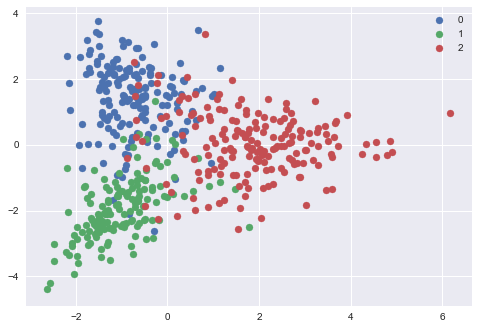

In [25]:
for yi in set(y_valid):
    mask = y_valid == yi
    plt.scatter(X_emb[mask, 0], X_emb[mask, 1], label=yi)
plt.legend()

## Predicting on the embeddings

We train a simple KNN classifier, once on the original input features, `X_valid`, and once on the embedded features, `X_emb`. The classifier is actually more accurate on the embedded features, meaning that the embeddings are indeed useful.

In [26]:
scores = cross_val_score(KNeighborsClassifier(), X_valid, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.6899049316696375

In [27]:
scores = cross_val_score(KNeighborsClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.8736874628639335

Just for completeness, we show that a dummy classifier performs much worse on the same data, proving that the results are not due to luck.

In [28]:
scores = cross_val_score(DummyClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.34170291146761733